## Fine-tuning CNN for AI-generated Image Detection
In this notebook, we will explore the task of classifying images as real or AI-generated using fine-tuning techniques with several well-known CNN architectures. For this classification task, we will use the CIFAKE dataset, which includes both real and AI-generated images.

Link for the dataset: [CIFAKE: Real and AI-Generated Synthetic Images](https://www.kaggle.com/datasets/birdy654/cifake-real-and-ai-generated-synthetic-images)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from IPython.display import Image

2024-02-22 17:23:43.492926: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-22 17:23:43.493033: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-22 17:23:43.621745: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
dataset_dir = "/kaggle/input/cifake-real-and-ai-generated-synthetic-images/" # For Kaggle notebooks. If you run locally, point this line to the CIFAKE directory
print("Loading dataset from: " + dataset_dir)

Loading dataset from: /kaggle/input/cifake-real-and-ai-generated-synthetic-images/


In [3]:
# Check if GPUs are available for training 
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [4]:
img_height = 32
img_width = 32
batch_size = 500

# Load the training data
train_ds = tf.keras.utils.image_dataset_from_directory(
  dataset_dir + "/train",
  seed = 512,
  image_size = (img_height, img_width),
  batch_size = batch_size)

# Load the validation data
val_ds = tf.keras.utils.image_dataset_from_directory(
  dataset_dir + "/test",
  seed = 512,
  image_size = (img_height, img_width),
  batch_size = batch_size)

print("Training Classes:")
class_names = train_ds.class_names
print(class_names)

print("Testing Classes:")
class_names = val_ds.class_names
print(class_names)

Found 100000 files belonging to 2 classes.
Found 20000 files belonging to 2 classes.
Training Classes:
['FAKE', 'REAL']
Testing Classes:
['FAKE', 'REAL']


Larger batch sizes are expected to result in significantly longer training times, especially with a substantial training set of 100,000 images. However, the compact size of the images effectively reduces the impact on training duration.

In [5]:
# Function for plotting the error rate and metrics rate
def plot_metrics(history, metric):
    plt.plot(history.history[metric], label = metric)
    plt.plot(history.history['val_' + metric], label='val_' + metric)
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.legend()
    plt.show()
    
# Constant values that will be shared by all the models
val_true_classes = np.concatenate([y for x, y in val_ds], axis = 0)  # Get true labels
class_names = ['FAKE', 'REAL']
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 10, restore_best_weights = True) 

### Model

In [22]:
# Building the Transfer Learning model using MobileNetV3
MobileNet_base_model = tf.keras.applications.MobileNetV3Small(
    include_top = False, 
    weights = 'imagenet', 
    input_shape = (img_height, img_width, 3),
    pooling = 'max'
)
MobileNet_base_model.trainable = True

# Create a new model on top of the MobileNet base
inputs = tf.keras.Input(shape = (img_height, img_width, 3))
x = MobileNet_base_model(inputs, training = False)
x = BatchNormalization(axis = -1, momentum = 0.99, epsilon = 0.001)(x)
x = Dense(256, 
          kernel_regularizer = regularizers.l2(0.01), 
          activity_regularizer = regularizers.l1(0.01), 
          bias_regularizer = regularizers.l1(0.01),
          activation = 'relu')(x)
x = Dropout(rate = .4, seed = 512)(x)       
x = Dense(64, activation = 'relu')(x)
outputs = Dense(1, activation = 'sigmoid')(x)
MobileNet_model = tf.keras.Model(inputs, outputs)

# Compile the Transfer Learning model
MobileNet_model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.BinaryCrossentropy(),
    metrics = ['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

# Build the Transfer Learning model so we can see a summary
MobileNet_model.summary()

4334752/4334752 [==============================] - 0s 0us/step
Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 MobilenetV3small (Function  (None, 576)               939120    
 al)                                                             
                                                                 
 batch_normalization_3 (Bat  (None, 576)               2304      
 chNormalization)                                                
                                                                 
 dense_9 (Dense)             (None, 256)               147712    
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                              

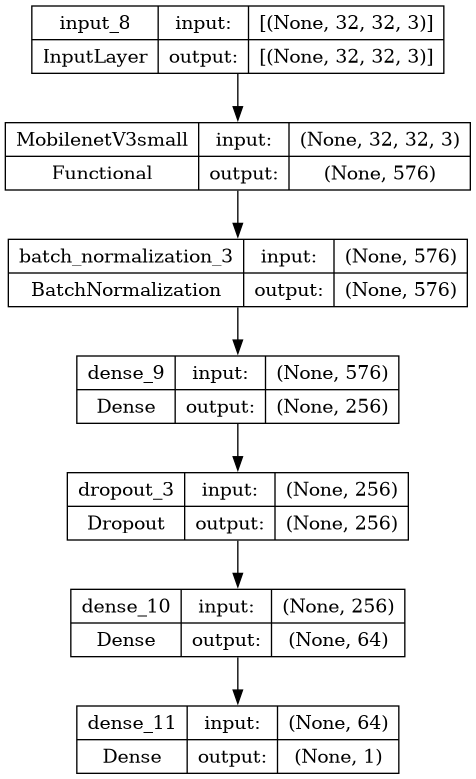

In [23]:
# Visualize the MobileNet model architecture
tf.keras.utils.plot_model(MobileNet_model, show_shapes = True, to_file = 'MobileNet_model.png')
Image('MobileNet_model.png')

In [24]:
# Finally, train the Transfer Learning model
print("Starting training with Transfer Learning using MobileNet...")
MobileNet_model_history = MobileNet_model.fit(
    train_ds,
    validation_data = val_ds,
    epochs = 100,
    verbose = 1,
    callbacks = [early_stopping]
)
print("Transfer Learning training finished.")

Starting training with Transfer Learning using MobileNet...
Epoch 1/100
200/200 [==============================] - 54s 134ms/step - loss: 0.9589 - accuracy: 0.8435 - precision_3: 0.8305 - recall_3: 0.8632 - val_loss: 0.2743 - val_accuracy: 0.9099 - val_precision_3: 0.9638 - val_recall_3: 0.8518
Epoch 2/100
200/200 [==============================] - 28s 137ms/step - loss: 0.2060 - accuracy: 0.9332 - precision_3: 0.9339 - recall_3: 0.9324 - val_loss: 0.5098 - val_accuracy: 0.8163 - val_precision_3: 0.9955 - val_recall_3: 0.6355
Epoch 3/100
200/200 [==============================] - 27s 133ms/step - loss: 0.1668 - accuracy: 0.9445 - precision_3: 0.9460 - recall_3: 0.9428 - val_loss: 0.1599 - val_accuracy: 0.9453 - val_precision_3: 0.9412 - val_recall_3: 0.9501
Epoch 4/100
200/200 [==============================] - 29s 141ms/step - loss: 0.1491 - accuracy: 0.9506 - precision_3: 0.9511 - recall_3: 0.9501 - val_loss: 0.3109 - val_accuracy: 0.9010 - val_precision_3: 0.9900 - val_recall_3: 0.8

In [25]:
# Evaluate the model on the test dataset
val_loss, val_accuracy, val_precision, val_recall = MobileNet_model.evaluate(val_ds)

# Print the metrics
print(f"Val Loss: {val_loss:.4f}")
print(f"Val Accuracy: {val_accuracy:.4f}")
print(f"Val Precision: {val_precision:.4f}")
print(f"Val Recall: {val_recall:.4f}")

40/40 [==============================] - 4s 74ms/step - loss: 0.1394 - accuracy: 0.9528 - precision_3: 0.9399 - recall_3: 0.9676
Val Loss: 0.1394
Val Accuracy: 0.9528
Val Precision: 0.9399
Val Recall: 0.9676


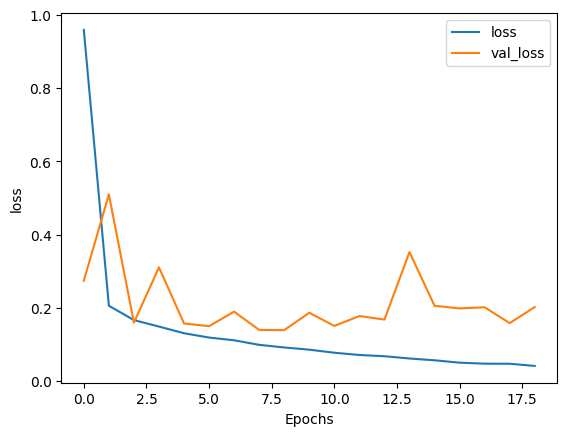

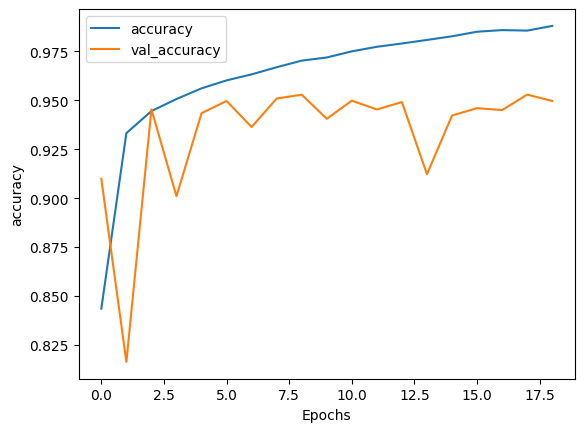

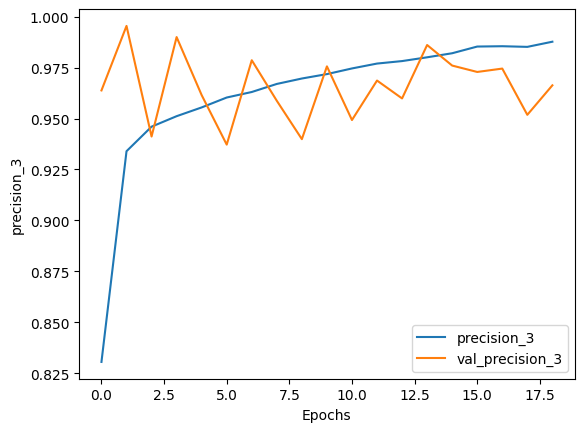

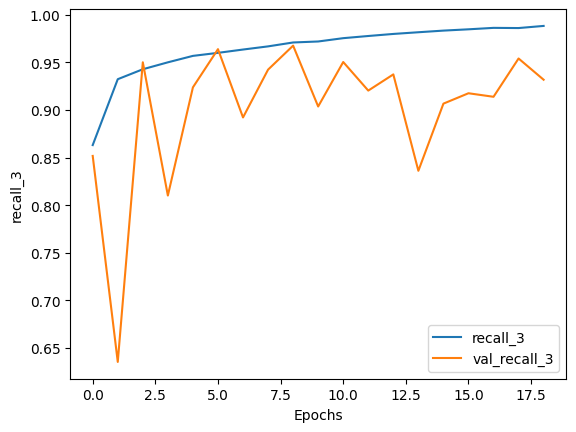

In [26]:
# Plot error rates and metric rates
plot_metrics(MobileNet_model_history, 'loss')
plot_metrics(MobileNet_model_history, 'accuracy')
plot_metrics(MobileNet_model_history, 'precision_3')
plot_metrics(MobileNet_model_history, 'recall_3')

In [27]:
# Save the MobileNet model
MobileNet_model.save("MobileNet_model.h5")

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


The model with EfficientNet as the base is the clear winner with an accuracy of 97.29%; however, MobileNet is also a great option since its model size is significantly lower than EfficientNet's, with a minor decrease in performance.